In [3]:
# imports
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [4]:
data = pd.read_csv('data/tiny.csv')

In [5]:
# Create a connection to an in-memory SQLite database
conn = sqlite3.connect(':memory:')

# Load the DataFrame into the SQLite database
data.to_sql('mlperf', conn, index=False)

# Verify the table creation by querying the SQLite master table
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,mlperf


In [6]:
query = 'SELECT DISTINCT "Model MLC" FROM mlperf'
models = pd.read_sql_query(query, conn)
print(models)

             Model MLC
0                DSCNN
1       FC AutoEncoder
2  MobileNetV1 (0.25x)
3            ResNet-V1
4                 None
5               Conv2D
6                Dense
7     Deep AutoEncoder
8    MobileNetV1 0.25x


For the context of SSL, the most interesting models to observe are ResNet-V1 and MobileNetV1 (0.25x). Let's clean the DB by making "MobileNetV1 (0.25x)" and "MobileNetV1 0.25x" the same thing

In [7]:
query = """
UPDATE mlperf
SET `Model MLC` = 'MobileNetV1 (0.25x)'
WHERE `Model MLC` = 'MobileNetV1 0.25x';
"""

# Execute the update query
conn.execute(query)

# Lets check the models again
query = 'SELECT DISTINCT "Model MLC" FROM mlperf'
models = pd.read_sql_query(query, conn)
print(models)

             Model MLC
0                DSCNN
1       FC AutoEncoder
2  MobileNetV1 (0.25x)
3            ResNet-V1
4                 None
5               Conv2D
6                Dense
7     Deep AutoEncoder


In [8]:
query = """
SELECT * FROM mlperf
WHERE `Model MLC` = 'MobileNetV1 (0.25x)';
"""

mobilenet_data = pd.read_sql_query(query, conn)
mobilenet_data.to_sql('mobilenet', conn, index=False)

108

In [9]:
query = """
SELECT 
    `System Name`,
    `Latency (ms)`,
    `Energy (µJ)`
FROM(
    SELECT 
        `System Name (Click + for details)` AS `System Name`,
        MAX(CASE WHEN Units = 'Latency in ms' THEN `Avg. Result` ELSE NULL END) AS `Latency (ms)`,
        MAX(CASE WHEN Units = 'Energy in uJ' THEN `Avg. Result` ELSE NULL END) AS `Energy (µJ)`
    FROM 
        mobilenet
    GROUP BY 
        `System Name (Click + for details)`
)
WHERE 
    `Latency (ms)` IS NOT NULL AND `Energy (µJ)` IS NOT NULL;
"""

mn_filtered_results = pd.read_sql_query(query, conn)
mn_filtered_results

,System Name,Latency (ms),Energy (µJ)
0,EFR32MG24,111.61000,1139.220
1,EK-RA6M4,162.36400,11851.800
2,GAP9,1.73300,58.356
3,NDP120,12.70000,97.160
4,NUCLEO-H7A3ZI-Q,64.37000,10487.700
5,NUCLEO-H7A3ZI-Q-X-CUBE-AI-7.3,50.40830,7810.700
6,NUCLEO-H7A3ZI-Q-X-CUBE-AI-8.0,50.33470,6928.310
7,NUCLEO-L4R5ZI,254.64700,12293.300
8,NUCLEO-L4R5ZI-X-CUBE-AI-7.3,224.92100,16536.300
9,NUCLEO-L4R5ZI-X-CUBE-AI-8.0,221.14100,16573.100


/tmp/ipykernel_607/435231631.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipykernel_607/435231631.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_607/435231631.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


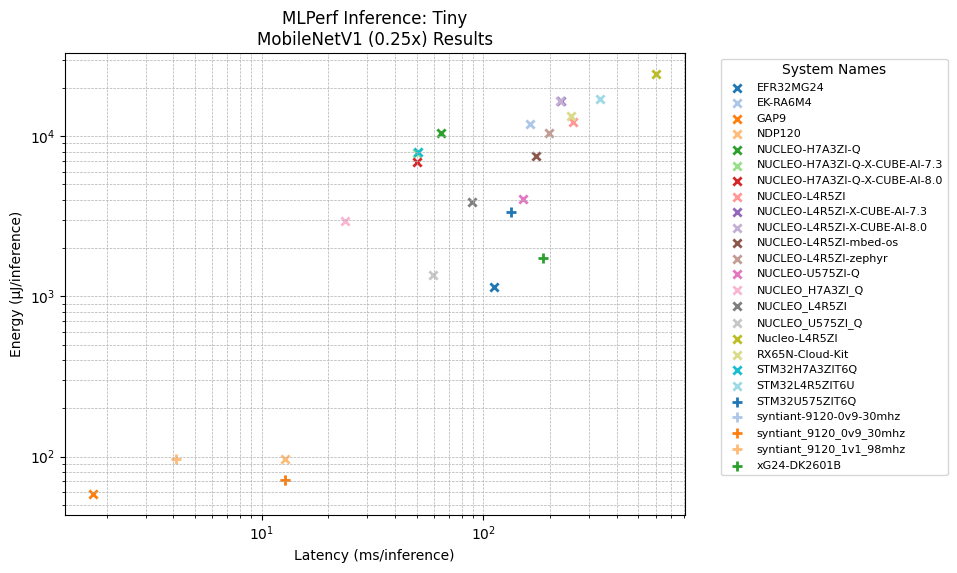

In [10]:
colormap = plt.cm.tab20
markers = ["x", "+", "*"]

plt.figure(figsize=(8, 6))

# Scatter plot with distinct colors and marker styles
for i, system in enumerate(mn_filtered_results["System Name"]):
    color_index = i % len(colormap.colors)
    marker_index = i // len(colormap.colors)

    # Adjust marker size and line width based on marker type
    marker_size = 50 if markers[marker_index] in ["+"] else 35

    plt.scatter(
        mn_filtered_results["Latency (ms)"][i],
        mn_filtered_results["Energy (µJ)"][i],
        c=colormap(color_index),
        alpha=1.0,
        marker=markers[marker_index],
        s=marker_size,
        linewidths=2,
        edgecolors="black",
        label=system,
    )

plt.title("MLPerf Inference: Tiny\nMobileNetV1 (0.25x) Results")
plt.xlabel("Latency (ms/inference)")
plt.ylabel("Energy (µJ/inference)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--", linewidth=0.5)  # Adjust grid line width
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Move legend outside the plot
plt.legend(title="System Names", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
plt.savefig("vww.svg")
plt.show()


In [11]:
query = """
SELECT * FROM mlperf
WHERE `Model MLC` = 'ResNet-V1';
"""

rn_data = pd.read_sql_query(query, conn)
rn_data.to_sql('rn', conn, index=False)

113

In [12]:
query = """
SELECT 
    `System Name`,
    `Latency (ms)`,
    `Energy (µJ)`
FROM(
    SELECT 
        `System Name (Click + for details)` AS `System Name`,
        MAX(CASE WHEN Units = 'Latency in ms' THEN `Avg. Result` ELSE NULL END) AS `Latency (ms)`,
        MAX(CASE WHEN Units = 'Energy in uJ' THEN `Avg. Result` ELSE NULL END) AS `Energy (µJ)`
    FROM 
        rn
    GROUP BY 
        `System Name (Click + for details)`
)
WHERE 
    `Latency (ms)` IS NOT NULL AND `Energy (µJ)` IS NOT NULL;
"""

rn_filtered_results = pd.read_sql_query(query, conn)

/tmp/ipykernel_607/3128110039.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/tmp/ipykernel_607/3128110039.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(
/tmp/ipykernel_607/3128110039.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


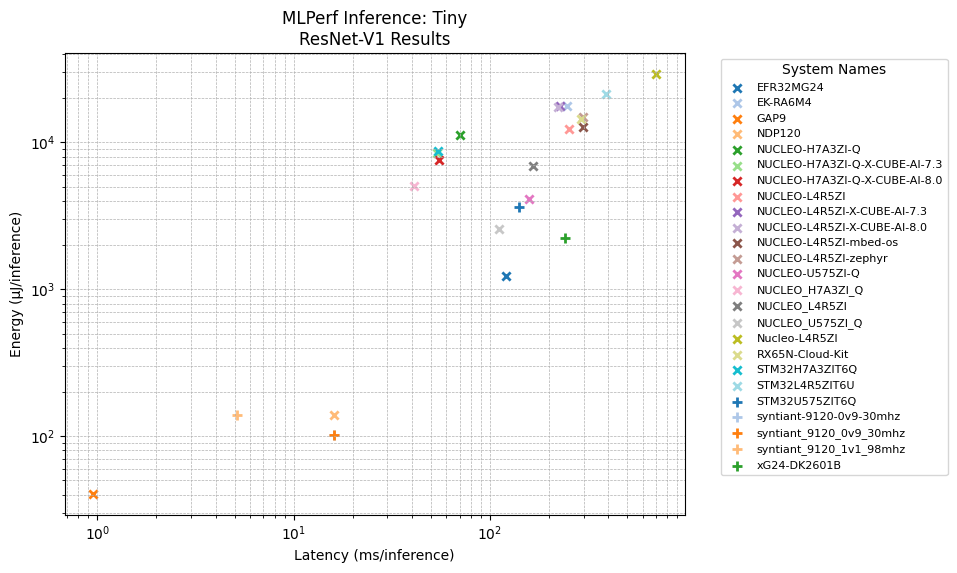

In [13]:
colormap = plt.cm.tab20
markers = ["x", "+", "*"]

plt.figure(figsize=(8, 6))

# Scatter plot with distinct colors and marker styles
for i, system in enumerate(rn_filtered_results["System Name"]):
    color_index = i % len(colormap.colors)
    marker_index = i // len(colormap.colors)

    # Adjust marker size and line width based on marker type
    marker_size = 50 if markers[marker_index] in ["+"] else 35

    plt.scatter(
        rn_filtered_results["Latency (ms)"][i],
        rn_filtered_results["Energy (µJ)"][i],
        c=colormap(color_index),
        alpha=1.0,
        marker=markers[marker_index],
        s=marker_size,
        linewidths=2,
        edgecolors="black",
        label=system,
    )

plt.title("MLPerf Inference: Tiny\nResNet-V1 Results")
plt.xlabel("Latency (ms/inference)")
plt.ylabel("Energy (µJ/inference)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--", linewidth=0.5)  # Adjust grid line width
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Move legend outside the plot
plt.legend(title="System Names", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

plt.savefig("ic.svg")
plt.show()